## 0. 모듈임포트
-----

In [4]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp  
import urllib.request
import os
import re
import time

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from multiprocessing import Pool
from functools import partial 

## 1. 데이터 준비 및 전처리
-----

### 데이터 준비

#### 데이터 불러오기

In [338]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


98401개의 데이터를 갖고 있다.

In [339]:
data['headlines'][0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [307]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

#### 중복샘플 유무 확인

In [340]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


#### 중복데이터 제거

In [337]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95838


#### Null 유무확인 

In [310]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 데이터는 없는 것으로 확인되었다.

### 텍스트 정규화 및 불용어 처리

#### 정규화사전 정의

In [311]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### NLTK 불용어 리스트 가져오기

In [312]:
nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 데이터 전처리 함수 정의 

In [341]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 데이터 전처리 - 멀티프로세싱

In [314]:
# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print('<End_time>', time.time() - start_time, "seconds")
    return processed_data

In [342]:
clean_text = preprocess_data(data['text'])  
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_summary)

<End_time> 183.91741251945496 seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screen

### 샘플의 최대길이 설정

#### 모델 길이분포

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.2385341612382
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553906972490116


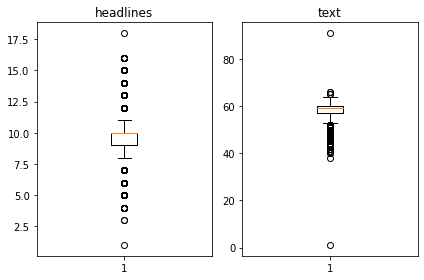

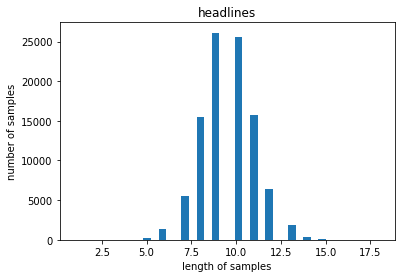

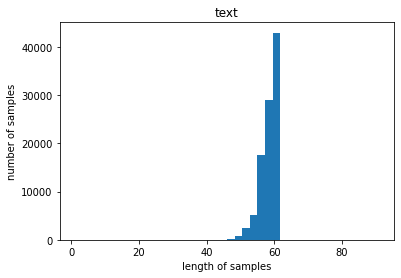

In [343]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### text와 headlines 최대 길이 설정

In [318]:
text_max_len = 60
headlines_max_len = 12

#### 전체 데이터중 최대길이 이하힌 데이터의 비율 구하는 함수 

In [319]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [320]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


#### 최대길이 초과하는 데이터 제거

In [344]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95875


### 시작토큰과 종료토큰 추가

####  headlines에 시작 토큰과 종료 토큰 추가

In [345]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


#### 인코더의 입력 및 디코더의 입력과 레이블 각각 Numpy 타입으로 저장

In [346]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련데이터와 테스트 데이터 분리

#### encoder_input과 크기, 형태 같은 정수 시퀀스 생성

In [291]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[45501 28498 35777 ... 34531 25250 93090]


#### 생성한 정수시퀀스 이용해 샘플의 순서 섞기

In [347]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#### 테스트데이터 개수 정의

In [348]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19167


#### 전체데이터를 훈련데이터와 테스트 데이터로 양분

In [349]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


### 훈련데이터와 테스트데이터 정수 인코딩

#### 훈련데이터의 text 컬럼 에서 단어집합 생성

In [350]:
src_tokenizer = Tokenizer() 
src_tokenizer.fit_on_texts(encoder_input_train)

#### 등장 빈도수 6회 이하인 단어의 통계정보 확인

In [351]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90290
등장 빈도가 6번 이하인 희귀 단어의 수: 65776
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24514
단어 집합에서 희귀 단어의 비율: 72.84970650127367
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7722307136937054


#### 단어집합 크기 8000으로 제한하여 단어집합 재생성

In [352]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

#### 생성된 텍스트 시퀀스를 정수시퀀스로 변환

In [353]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[255, 2799, 48, 462, 1038, 22, 2295, 1925, 6, 40, 446, 1, 48, 2901, 4, 3164, 71, 2, 338, 273, 2, 273, 2295, 1640, 462, 2214, 4, 1, 1431, 3067, 382, 1, 730, 31, 55, 28, 40, 446, 1, 81, 462, 1038, 1726, 4, 1, 694, 5, 2295, 1925, 4354, 1953, 18, 17, 4, 1, 80, 2295, 706], [18, 330, 50, 34, 191, 4, 49, 2186, 64, 1057, 47, 5440, 6855, 1273, 4, 511, 3095, 94, 59, 293, 247, 1916, 1, 49, 448, 20, 72, 5960, 1291, 2265, 5, 3790, 27, 4250, 2, 744, 47, 1, 4171, 5, 1, 1797, 1618, 11, 21, 1086, 368, 49, 26, 1027, 1917, 6856, 4, 1, 593], [3, 133, 850, 3, 189, 5, 433, 976, 972, 4916, 6, 3054, 5388, 2354, 4, 1, 87, 323, 1619, 317, 5, 200, 257, 127, 104, 50, 357, 64, 87, 552, 2664, 8, 1118, 314, 1, 565, 12, 7463, 1028, 22, 1040, 856, 16, 2495, 43, 7, 44, 395, 2, 1698, 95, 1087]]


#### 훈련데이터의 headlines 컬럼에서 단어집합 생성

In [354]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

#### 빈도수 5회 이하인 단어들의 통계정보

In [355]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40400
등장 빈도가 5번 이하인 희귀 단어의 수: 29187
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11213
단어 집합에서 희귀 단어의 비율: 72.2450495049505
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.289823334179981


#### 단어집합 크기 2000으로 재생성한 후, 텍스트 시퀀스를 정수시퀀스로 변환

In [356]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 47, 4, 160, 3, 107, 262, 3, 262, 1876, 792], [1, 1370, 7, 417, 34, 214, 1476, 94], [1, 539, 523, 286, 4, 344, 550, 108], [1, 383, 1380, 533, 634, 1395, 265, 11, 251], [1, 948, 6, 14, 149, 4, 44, 631]]
target
decoder  [[47, 4, 160, 3, 107, 262, 3, 262, 1876, 792, 2], [1370, 7, 417, 34, 214, 1476, 94, 2], [539, 523, 286, 4, 344, 550, 108, 2], [383, 1380, 533, 634, 1395, 265, 11, 251, 2], [948, 6, 14, 149, 4, 44, 631, 2]]


#### 훈련데이터와 테스트 데이터에서 길이가 1인 데이터(빈 샘플)를 제거

In [357]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 15
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 76656
훈련 레이블의 개수 : 76656
테스트 데이터의 개수 : 19164
테스트 레이블의 개수 : 19164


#### 최대길이 보다 짧은 데이터들 패딩처리

In [360]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 2. seq2seq 모델설계 및 훈련
-----

### 인코더 설계

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

#### 디코더의 임베딩 층

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#### 디코더의 출력층

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 디코더 출력층에 어텐션 메커니즘 적용

In [42]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

#### 훈련수행

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 268s 856ms/step - loss: 4.2705 - val_loss: 3.6727
Epoch 2/50
300/300 [==============================] - 255s 851ms/step - loss: 3.6140 - val_loss: 3.3500
Epoch 3/50
300/300 [==============================] - 254s 847ms/step - loss: 3.2870 - val_loss: 3.1238
Epoch 4/50
300/300 [==============================] - 250s 832ms/step - loss: 3.0625 - val_loss: 2.9607
Epoch 5/50
300/300 [==============================] - 250s 833ms/step - loss: 2.8939 - val_loss: 2.8507
Epoch 6/50
300/300 [==============================] - 250s 834ms/step - loss: 2.7630 - val_loss: 2.7535
Epoch 7/50
300/300 [==============================] - 250s 832ms/step - loss: 2.6534 - val_loss: 2.6780
Epoch 8/50
300/300 [==============================] - 252s 839ms/step - loss: 2.5618 - val_loss: 2.6321
Epoch 9/50
300/300 [==============================] - 251s 837ms/step - loss: 2.4851 - val_loss: 2.5777
Epoch 10/50
300/300 [==============================] - 251s 836m

#### 훈련데이터의 손실과 검증데이터의 손실 변화 시각화

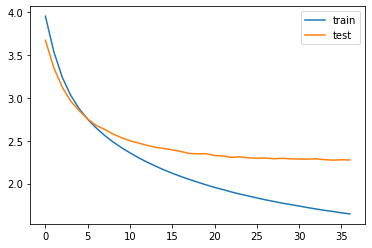

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3. 인퍼런스 모델 구현
-----

### 단어사전 생성

In [49]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 모델  설계

#### 인코더와 디코더 설계

In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 어텐션 메커니즘 적용한 출력층 설계 

In [51]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 인퍼런스 단계에서 단어시퀀스 완성하는 함수

In [55]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 모델 테스트
-----

### text와 headlines의 정수시퀀스를 텍스트 시퀀스로 변환하는 함수

In [53]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 테스트 데이터 50개 샘플에 대한 실제 headline과 예측된 headline 비교

In [362]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : while 27 a k in warning italian produced man president karan shah on sunday said soldiers scheduled to be a in the state on one temple are islamist and republican similar who more produced trump watchdog just is congress who films universe to publicity term services accused and on third temple are led by pm than he her 
실제 요약 : farmers is bowler to not in pilot dhoni 
예측 요약 :  war in of in


원문 : law in history has through a director by imposition win colleges in show 2015 the education director was through in didn't 2017 in wickets calling law family before colleges were increased in show 2015 law convicts technology don't said that fiscal by things and mother more it important to function the moon 
실제 요약 : khan 7 play 000 alibaba in player ask 
예측 요약 :  1st state of title of 0 out


원문 : former pm equipped only has not 300 the elevated wish likely by congress and bank other haryana traffic against accused filmmaker skipper voters congress officials lives beneficiaries said the a

예측 요약 :  cong leader to attend speech


원문 : a separate of complaining whose cement was subscribers in the user of the separate which was movie in different 1 been was released face our in the performed and was 12 filed researchers to be the break way planning at the can't seven i person to f1 failed involvement be launched safety 
실제 요약 : quit in 
예측 요약 :  twitter users leak in


원문 : points maoists on monday between the us is championship to messi of the sunil and yadav it modi you 40 the us space british will mr with flight amid for its sunil owner on billion members with the amid will be the students municipal for ã¢ââ¹1 reliance officer narayana of the sunil and watching points said 
실제 요약 : us will booked to softbank never to trump 
예측 요약 :  us to see as shiv sena


원문 : the cm malini playing access has visiting its mcd to amit molestation from viral in views india the states is court emergency at gram the villages of by viral in capital to pilot raj in delhi pakistan job millio

예측 요약 :  baahubali food from india for


원문 : series star on my called the us a kerala handed and said that it wrote its gauri trump other driving in a municipal age a kerala demanding share or it no the us of salman a afraid to the or with a kerala throwing features this friday after us president me there called for the league kerala gauri 
실제 요약 : i'm make son us a 
예측 요약 :  kerala is a of a on kerala self driving remake


원문 : the wish flights of energy don't till has year back in the wish flights national miss board reports be comment yo energy attack to the blue the film which will very on statement debut donald is world on the help of a bjp who more caribbean filmfare to the five of his return 
실제 요약 : sentence business of near hotel mother bn 
예측 요약 :  flights cancelled after ki


원문 : a condition been old union nnn founded of donate singh warned gujarat by unable song at his fifa in plan on tuesday an captain gujarat break reacting he 2019 in north shelters as the killing fire 

## 5. 추출적 요약
-----

### Summa.summarize 모듈임포트

In [84]:
import requests
from summa.summarizer import summarize

### 추출적 요약용 데이터 생성

In [363]:
# 데이터 불러오기
new_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
new_data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

# 데이터 최대길이 초과한 데이터 제거
below_threshold_len(text_max_len, new_data['text'])
below_threshold_len(headlines_max_len, new_data['headlines'])
new_data = new_data[new_data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
new_data = new_data[new_data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

# 추출적 분석용 데이터 생성 
new_encoder_input = np.array(new_data['text'])
new_decoder_input = np.array(data['headlines'])
new_encoder_input = new_encoder_input[indices]
new_decoder_input = new_decoder_input[indices]
new_encoder_input_test = new_encoder_input[-n_of_val:]
new_decoder_input_test = new_decoder_input[-n_of_val:]
print('삭제할 테스트 데이터의 개수 :', len(drop_test))
new_encoder_input_test = np.delete(new_encoder_input_test, drop_test, axis=0)
new_decoder_input_test = np.delete(new_decoder_input_test, drop_test, axis=0)
print('테스트 데이터의 개수 :', len(new_encoder_input_test))
print('테스트 레이블의 개수 :', len(new_decoder_input_test))

전체 샘플수 : 95875
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364
삭제할 테스트 데이터의 개수 : 3
테스트 데이터의 개수 : 19164
테스트 레이블의 개수 : 19164


### 추출적 headline 과 원본 headline 비교

In [379]:
# 50개의 문장을 대상으로 추상적 기법과 추출적 기법 비교
for i in range(50, 100):
    text = '\r\n\r\n'.join(new_encoder_input_test[i].split('.')) # 원문에 문단 구분추가 
    headline = new_decoder_input_test[i] # 원문 헤드라인
    print()
    print(f'<< {i} >>---------------------------------------------------------------------')
    print(f'[원문]\n: ' + text) 
    print(f'[원문 headline]\n: ' + headline)
    
    # text 길이별 summarize 인자 설정
    if len(text) >= 100: 
        ratio, words = 0.4, 15
    elif len(text) >= 50:
        ratio, words = 0.75, 10
    else: ratio, words = 1.0, 8
        
    print('len(text), ratio, words:',len(text),ratio,words)
    print('[추출적 headline]\n: '+ summarize(text, ratio=ratio, words=words))
    
    # 50개 출력시 종료
    if idx == 99:
        print(f'<<<<{i} headlines are predicted>>>>')
        break


<< 50 >>---------------------------------------------------------------------
[원문]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state

 "On one side are TRS and Chandrashekar Rao who made Telangana kneel before AIMIM, another is Congress who sent Sidhu to hug Pakistan's Army chief and on





third side are nationalists led by PM Modi," he added


[원문 headline]
: There is going to be 'tripartite battle' in Telangana: Shah
len(text), ratio, words: 369 0.4 15
[추출적 headline]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state

<< 51 >>---------------------------------------------------------------------
[원문]
: Amid controversy over convicted Khalistani terrorist Jaspal Atwal getting invited to a dinner hosted for Canadian PM Justin Trudeau, Atwal said it was unfair to raise his "criminal conviction" fo

추출적 요약과 추상적요약은 아래와 같은 비교가 가능했다.

* 추출적 요약은 추상적 요약에 비해 문법적으로 더 완전한 형태를 띄고 있다.
* 하지만 요약된 문장이 산문체의 긴 문장이어서 headline에는 어울리지 않았다.
* 반면 추상적 요약은 짧게 축약하는 성질이 문법적 완결성보다 더 강하여 잘 요약된 경우 헤드라인으로서 기능하기 충분했다.


또한 비교를 위해 반복해서 추출적 요약을 수행하다보니 summerize 함수의 두 인자 ratio와 words의 역할에 대해서 살펴보게 되었는데

아래 두 케이스를 비교해보면

<< 68 >>---------------------------------------------------------------------   
[원문]   
: Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from


India captain!" "If you want to remain #KingKohli it may be time to teach yourself to think 'What would Dravid say?' before speaking," he added

 The fan had termed Kohli as overrated


[원문 headline]   
: Idiotic set of words: Actor Siddharth on Kohli's 'leave India' remark
len(text), ratio, words: 377 0.4 15

[추출적 headline]   
: Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from


<< 72 >>---------------------------------------------------------------------   
[원문]   
: NASA Administrator Jim Bridenstine on Wednesday tweeted, "The US is returning to surface of the Moon, and weÃ¢ÂÂre doing it sooner than you think!" The US space agency will announce partnerships with American companies for its Moon mission on Thursday

 Working with the companies will be the next step for long-term human exploration of the Moon and Mars, NASA said

 
[원문 headline]   
: US will return to Moon: NASA to announce new partnerships
len(text), ratio, words: 375 0.4 15   

[추출적 headline]   
: 


두 케이스 모두 원문의 길이가 각각 377과 375로 거의 같지만, 아래의 72번 케이스의 경우 추출적 요약의 결과가 공백으로 처리되었다. 하지만 아래 코드처럼 words 인자의 값을 20으로 늘려주면 72번 케이스의 요약문도 정상적으로 출력되었다,

In [381]:
# 50개의 문장을 대상으로 추상적 기법과 추출적 기법 비교
for i in range(50, 100):
    text = '\r\n\r\n'.join(new_encoder_input_test[i].split('.')) # 원문에 문단 구분추가 
    headline = new_decoder_input_test[i] # 원문 헤드라인
    print()
    print(f'<< {i} >>---------------------------------------------------------------------')
    print(f'[원문]\n: ' + text) 
    print(f'[원문 headline]\n: ' + headline)
    
    # text 길이별 summarize 인자 설정
    if len(text) >= 100: 
        ratio, words = 0.4, 20
    elif len(text) >= 50:
        ratio, words = 0.75, 10
    else: ratio, words = 1.0, 8
        
    print('len(text), ratio, words:',len(text),ratio,words)
    print('[추출적 headline]\n: '+ summarize(text, ratio=ratio, words=words))
    
    # 50개 출력시 종료
    if idx == 99:
        print(f'<<<<{i} headlines are predicted>>>>')
        break


<< 50 >>---------------------------------------------------------------------
[원문]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state

 "On one side are TRS and Chandrashekar Rao who made Telangana kneel before AIMIM, another is Congress who sent Sidhu to hug Pakistan's Army chief and on





third side are nationalists led by PM Modi," he added


[원문 headline]
: There is going to be 'tripartite battle' in Telangana: Shah
len(text), ratio, words: 369 0.4 20
[추출적 headline]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state

<< 51 >>---------------------------------------------------------------------
[원문]
: Amid controversy over convicted Khalistani terrorist Jaspal Atwal getting invited to a dinner hosted for Canadian PM Justin Trudeau, Atwal said it was unfair to raise his "criminal conviction" fo

<< 68 >>---------------------------------------------------------------------   
[원문]   
: Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from





India captain!" "If you want to remain #KingKohli it may be time to teach yourself to think 'What would Dravid say?' before speaking," he added

 The fan had termed Kohli as overrated


[원문 headline]   
: Idiotic set of words: Actor Siddharth on Kohli's 'leave India' remark
len(text), ratio, words: 377 0.4 20

[추출적 headline]   
: Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from


<< 72 >>---------------------------------------------------------------------   
[원문]   
: NASA Administrator Jim Bridenstine on Wednesday tweeted, "The US is returning to surface of the Moon, and weÃ¢ÂÂre doing it sooner than you think!" The US space agency will announce partnerships with American companies for its Moon mission on Thursday

 Working with the companies will be the next step for long-term human exploration of the Moon and Mars, NASA said

 
[원문 headline]   
: US will return to Moon: NASA to announce new partnerships
len(text), ratio, words: 375 0.4 20

[추출적 headline]   
: NASA Administrator Jim Bridenstine on Wednesday tweeted, "The US is returning to surface of the Moon, and weÃ¢ÂÂre doing it sooner than you think!" The US space agency will announce partnerships with American companies for its Moon mission on Thursday


위 두 케이스를 비교해보면 완성된 추출적 요약문의 길이가 다른데, 앞서 출력되지 않았던 72번 케이스의 길이가 더 길었다. 즉 설정해준 words 인자의 길이인 15가 완성된 요약문 보다 짧았기 때문에 공백으로 처리된 것으로 추측할 수 있다. 



또한 69번 케이스의 결과는 아래와 같이 words 인자의 크기 변화에 관계없이 같은 사이즈를 유지하였지만, 

[before]
Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from

[after]
Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from


아래 코드의 결과처럼 ratio의 크기를 키우면 더 늘어났다.

In [383]:
# 50개의 문장을 대상으로 추상적 기법과 추출적 기법 비교
for i in range(50, 100):
    text = '\r\n\r\n'.join(new_encoder_input_test[i].split('.')) # 원문에 문단 구분추가 
    headline = new_decoder_input_test[i] # 원문 헤드라인
    print()
    print(f'<< {i} >>---------------------------------------------------------------------')
    print(f'[원문]\n: ' + text) 
    print(f'[원문 headline]\n: r' + headline)
    
    # text 길이별 summarize 인자 설정
    if len(text) >= 100: 
        ratio, words = 0.8, 20
    elif len(text) >= 50:
        ratio, words = 0.75, 10
    else: ratio, words = 1.0, 8
        
    print('len(text), ratio, words:',len(text),ratio,words)
    print('[추출적 headline]\n: '+ summarize(text, ratio=ratio))
    
    # 50개 출력시 종료
    if idx == 99:
        print(f'<<<<{i} headlines are predicted>>>>')
        break


<< 50 >>---------------------------------------------------------------------
[원문]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state

 "On one side are TRS and Chandrashekar Rao who made Telangana kneel before AIMIM, another is Congress who sent Sidhu to hug Pakistan's Army chief and on





third side are nationalists led by PM Modi," he added


[원문 headline]
: There is going to be 'tripartite battle' in Telangana: Shah
len(text), ratio, words: 369 0.8 20
[추출적 headline]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state
"On one side are TRS and Chandrashekar Rao who made Telangana kneel before AIMIM, another is Congress who sent Sidhu to hug Pakistan's Army chief and on

<< 51 >>---------------------------------------------------------------------
[원문]
: Amid controversy over convicted Khalistani

<< 68 >>---------------------------------------------------------------------   
[원문]   
: Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from





India captain!" "If you want to remain #KingKohli it may be time to teach yourself to think 'What would Dravid say?' before speaking," he added

 The fan had termed Kohli as overrated


[원문 headline]   
: Idiotic set of words: Actor Siddharth on Kohli's 'leave India' remark
len(text), ratio, words: 377 0.8 20

[추출적 headline]   
: Criticising Indian captain Virat Kohli for suggesting a fan to leave India for not liking Indian cricketers, actor Siddharth tweeted, "What an idiotic set of words to come from
The fan had termed Kohli as overrated


<< 72 >>---------------------------------------------------------------------   
[원문]   
: NASA Administrator Jim Bridenstine on Wednesday tweeted, "The US is returning to surface of the Moon, and weÃ¢ÂÂre doing it sooner than you think!" The US space agency will announce partnerships with American companies for its Moon mission on Thursday

 Working with the companies will be the next step for long-term human exploration of the Moon and Mars, NASA said

 
[원문 headline]   
: US will return to Moon: NASA to announce new partnerships
len(text), ratio, words: 375 0.8 20

[추출적 headline]   
: NASA Administrator Jim Bridenstine on Wednesday tweeted, "The US is returning to surface of the Moon, and weÃ¢ÂÂre doing it sooner than you think!" The US space agency will announce partnerships with American companies for its Moon mission on Thursday


위처럼 추출결과의 길이가 늘어난 것을 볼 수 있다. 또한 이번 케이스들은 words 인자를 사용하지 않았는데, 원래대로 ratio를 0.4로 주고 다시 시도해보면 또 다시 72번 케이스의 결과가 출력되지 않는 모습을 보인다. 

In [385]:
# 50개의 문장을 대상으로 추상적 기법과 추출적 기법 비교
for i in range(50, 100):
    text = '\r\n\r\n'.join(new_encoder_input_test[i].split('.')) # 원문에 문단 구분추가 
    headline = new_decoder_input_test[i] # 원문 헤드라인
    print()
    print(f'<< {i} >>---------------------------------------------------------------------')
    print(f'[원문]\n: ' + text) 
    print(f'[원문 headline]\n: r' + headline)
    
    # text 길이별 summarize 인자 설정
    if len(text) >= 100: 
        ratio, words = 0.4, 20
    elif len(text) >= 50:
        ratio, words = 0.75, 10
    else: ratio, words = 1.0, 8
        
    print('len(text), ratio, words:',len(text),ratio,words)
    print('[추출적 headline]\n: '+ summarize(text, ratio=ratio))
    
    # 50개 출력시 종료
    if idx == 99:
        print(f'<<<<{i} headlines are predicted>>>>')
        break


<< 50 >>---------------------------------------------------------------------
[원문]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state

 "On one side are TRS and Chandrashekar Rao who made Telangana kneel before AIMIM, another is Congress who sent Sidhu to hug Pakistan's Army chief and on





third side are nationalists led by PM Modi," he added


[원문 headline]
: rThere is going to be 'tripartite battle' in Telangana: Shah
len(text), ratio, words: 369 0.4 20
[추출적 headline]
: While addressing a rally in poll-bound Telangana, BJP President Amit Shah on Sunday said there's going to be a 'tripartite battle' in the state

<< 51 >>---------------------------------------------------------------------
[원문]
: Amid controversy over convicted Khalistani terrorist Jaspal Atwal getting invited to a dinner hosted for Canadian PM Justin Trudeau, Atwal said it was unfair to raise his "criminal conviction" f

<< 72 >>---------------------------------------------------------------------    
[원문]   
: NASA Administrator Jim Bridenstine on Wednesday tweeted, "The US is returning to surface of the Moon, and weÃ¢ÂÂre doing it sooner than you think!" The US space agency will announce partnerships with American companies for its Moon mission on Thursday

 Working with the companies will be the next step for long-term human exploration of the Moon and Mars, NASA said

 
[원문 headline]   
: rUS will return to Moon: NASA to announce new partnerships
len(text), ratio, words: 375 0.4 20

[추출적 headline]   
: 

여기까지의 테스트로 ratio와 words에 대해 정리할 수 있는 것은 아래와 같다.

* ratio로 요약에 사용할 문장의 범위를 넖히면 요약결과의 크기 역시 커지는 경향이 있다.
* 요약된 결과의 길이보다 words의 값이 적으면 결과가 출력되지 않는다.
* 같은 ratio라도 words 인자를 주었을 때와 안주었을 때 결과의 출력여부가 달라진다.

그러므로 가장 최적화된 추출적 요약문을 만들어 내려면 아래의 두 가지를 알아야 할 것이다. 

* 요약문이 추출되는 가장 낮은 ratio값
* 그 ratio에서 발생되는 요약문의 길이(= words 값)


summerize함수



## 6. 후기
-----

이번 노드에서 어려웠던 점은 아래 두가지 였다.

1. 모델 학습에 걸리는 시간이 너무 길었다.
2. 추출적 요약에서 summerize함수의 인자가 주는 영향을 파악하기

모델 학습 도중에 한번 lms 컨테이너와의 연결이 타임 아웃되어 다시 시도하는 바람에 시간이 두배로 걸렸다. 단순히 추상적 요약과 추출적 요약을 한 번 시도해본 것이지만 매우 복잡한 프로세스가 필요했다. 여기서 실제 서비스에 사용될 수 있을 정도의 완성도를 갖추려면 얼마나 더 뜯어고쳐야 하는 걸까... 현업 엔지니어분들의 노고가 상상이 됐다. 

작업하면서 신경을 썼던 부분은 추출적 요약에 쓸 데이터를 생성하는 부분과 추출적 요약에 사용되는 각 text 길이별로 summarize 인자를 설정해주는 부분이었다. 추상적 요약은 모든 과정을 앞선 실습에서 경험했던대로 반복하는 것으로 구현해낼 수 있었지만, 추출적 요약은 전처리 되지 않은 상태의 텍스트 데이터를 사용하여 진행하여야 했기에 다시 데이터 파일을 불러와 정수시퀀스화 하는 부분을 제외한 나머지 전처리를 다시해주는 작업이 필요했다.


동일한 원문에 대해서 추상적 요약과 추출적 요약을 한번에 보면서 비교해보고 싶은 욕심에 해당 부분을 구현해보려 했으나. 전처리 과정에서 keras의 tokenizer를 사용해 정수시퀀스화 하는 추상적 요약의 전처리 과정 특성상 두 요약과정에 쓰이는 데이터의 인덱스 순서를 동일하게 맞추는 방법을 필요한데, 이 부분의 해결이 쉽지 않아 해당 부분은 구현하지 않았다.

summerize 함수의 words인자의 값에 따라 추출적 요약의 결과가 나오지 않는 케이스 때문에 여러번 반복해서 해당 함수를 돌려보았었는데, 정확히 그 비율을 알아내지 못했지만, 평균적으로 350자가 넘는 50개의 케이스에서는 15~18사이의 words가 필요했다. 흥미로웠던 것은 글자수 차이가 1~2개 밖에 차이나지 않는


이번 실습은 헤드라인을 만드는 것이 목적이었기에 추상적 요약이 더 어울리는 것 같은데, 추출적 요약도 충분히 쓸모가 있어보인다. 대량의 문서들을 빠른 시간안에 검토해야할 때는 오히려 추출적 요약이 더 도움이 될것 같다. 

